In [2]:
import sys
sys.path.append("../../../src")

from mask_dataset import MaskedDataset
from mask_dataset import MaskedDataset
from probe_evaluation import draw_active_neuron_heatmap
from prober import Prober
import numpy as np

dataset = MaskedDataset(model_name='mbert')
prober = Prober(dataset, device='cuda:5')

Load pre-saved file /home/xzhao/workspace/probing-mulitlingual/result/dataset-mbert/mlama-dataset.pkl for MaskedDataset instance


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
rels = []
for rel in dataset.rels:
    if dataset.rel_info[rel]['vi'] != dataset.rel_info[rel]['id']:
        rels.append(rel)
print(rels)

['P1001', 'P101', 'P103', 'P106', 'P108', 'P127', 'P1303', 'P131', 'P136', 'P1376', 'P138', 'P140', 'P1412', 'P159', 'P17', 'P176', 'P178', 'P19', 'P190', 'P20', 'P264', 'P27', 'P276', 'P279', 'P30', 'P31', 'P36', 'P361', 'P364', 'P37', 'P39', 'P407', 'P413', 'P449', 'P463', 'P47', 'P495', 'P527', 'P530', 'P740', 'P937', 'place_of_birth', 'place_of_death']


In [4]:
# Find uuid shared by en, af and ja
from pred_evaluation import get_full_match_matrix_by_uuid
langs, all_uuids, matrix = get_full_match_matrix_by_uuid(dataset)
# cand_langs = ['en', 'de', 'id', 'ms']
cand_langs = ['es', 'pt', 'nl', 'af']

ids = [langs.index(lang) for lang in cand_langs]
uuids = [
    all_uuids[idx]
    for idx in np.where(matrix[ids].sum(axis=0)==4)[0]]

for uuid in uuids:
    if dataset.display_uuid(uuid, "en") != dataset.display_uuid(uuid, "de") and dataset.display_uuid(uuid, "ms") != dataset.display_uuid(uuid, "id"):
        print(uuid, dataset.uuid_info_plain[uuid]['rel_uri'], dataset.display_uuid(uuid))


ms doesn't has information about 0009473c-a993-457d-8460-420da07ad524, display English instead
0009473c-a993-457d-8460-420da07ad524 P1001 flag of Jamaica is a legal term in Jamaica .
014ad914-8b8e-4209-b7c6-4faeaf734da0 P103 The native language of Jean-Baptiste Say is French .
ms doesn't has information about 0354d288-6b5b-4cce-90ef-73fb9353f63f, display English instead
0354d288-6b5b-4cce-90ef-73fb9353f63f P159 The headquarter of RB Leipzig is in Leipzig .
ms doesn't has information about 0488ace0-d4fa-416b-a2d9-4e764ee4d56f, display English instead
0488ace0-d4fa-416b-a2d9-4e764ee4d56f P178 Windows RT is developed by Microsoft .
ms doesn't has information about 07e3a05a-befb-44f5-ba28-ff201a7954b1, display English instead
07e3a05a-befb-44f5-ba28-ff201a7954b1 P176 Suzuki Escudo is produced by Suzuki .
0816b023-07e9-47b6-85c9-212c5301cbfb P937 Romano Prodi used to work in Rome .
0a5b0aa1-a548-41ed-afdd-5181dcee7994 P361 theoretical physics is part of physics .
ms doesn't has information 

In [5]:
# P1001, P47, P159
lang1, lang2, lang3, lang4 = 'en', 'de', 'id', 'ms'
available_rels = []
for rel in rels:
    sorted_uuids_en, ranked_uuids_en, probing_en = prober.probe_uuid_by_lang_rel(lang1, rel, cand_size=10000)
    sorted_uuids_da, ranked_uuids_da, probing_da = prober.probe_uuid_by_lang_rel(lang2, rel, cand_size=10000)
    sorted_uuids_id, ranked_uuids_id, probing_id = prober.probe_uuid_by_lang_rel(lang3, rel, cand_size=10000)
    sorted_uuids_ms, ranked_uuids_ms, probing_ms = prober.probe_uuid_by_lang_rel(lang4, rel, cand_size=10000)
    if probing_en[3] != None and probing_da[3] != None and probing_id[3] != None and probing_ms[3] != None:
        common_uuids = list(set(probing_en[3].keys()).intersection(set(probing_da[3].keys())).intersection(set(probing_id[3].keys())).intersection(set(probing_ms[3].keys())))
        if len(common_uuids) > 0:
            print(rel, len(common_uuids))
            available_rels.append(rel)

# for uuid in common_uuids[:5]:
#     print(uuid, dataset.uuid_info_plain[uuid]['rel_uri'], dataset.display_uuid(uuid))

P1001 81
P131 1
P1376 24
P138 1
P159 18
P17 1
P176 39
P178 48
P19 3
P190 3
P276 9
P279 3
P30 1
P36 22
P361 10
P407 2
P463 2
P47 7
P495 1
P527 3
P530 1
P740 1
P937 23


In [6]:
from scipy.stats import spearmanr, kendalltau
from tqdm import tqdm 

def measure_neuron_similarity(neuron_rank1, neuron_rank2, topk=50, method='spearmanr'):
    neuron_rank1 = neuron_rank1[:topk]
    neuron_rank2 = neuron_rank2[:topk]
    if method == "shared_neuron":
        corr = len(set(neuron_rank1).intersection(set(neuron_rank2))) / len(set(neuron_rank1).union(set(neuron_rank2)))
    elif method == "spearmanr":
        corr, _ = spearmanr(neuron_rank1, neuron_rank2)
    elif method == "kendalltau":
        corr, _ = kendalltau(neuron_rank1, neuron_rank2)
    return corr

uuid2score = {}
for rel in tqdm(available_rels):
    sorted_uuids_en, ranked_uuids_en, probing_en = prober.probe_uuid_by_lang_rel(lang1, rel, cand_size=10000)
    sorted_uuids_da, ranked_uuids_da, probing_da = prober.probe_uuid_by_lang_rel(lang2, rel, cand_size=10000)
    sorted_uuids_id, ranked_uuids_id, probing_id = prober.probe_uuid_by_lang_rel(lang3, rel, cand_size=10000)
    sorted_uuids_ms, ranked_uuids_ms, probing_ms = prober.probe_uuid_by_lang_rel(lang4, rel, cand_size=10000)
    common_uuids = list(set(probing_en[3].keys()).intersection(set(probing_da[3].keys())).intersection(set(probing_id[3].keys())).intersection(set(probing_ms[3].keys())))

    topk = 50
    for uuid in common_uuids:
        if not (dataset.display_uuid(uuid, lang1) != dataset.display_uuid(uuid, lang2) 
            and dataset.display_uuid(uuid, lang3) != dataset.display_uuid(uuid, lang4)):
            continue

        sim12 = measure_neuron_similarity(top_neuron_en, top_neuron_da)
        sim34 = measure_neuron_similarity(top_neuron_id, top_neuron_ms)
        simdiff = (measure_neuron_similarity(top_neuron_en, top_neuron_id) +  measure_neuron_similarity(top_neuron_en, top_neuron_ms) + measure_neuron_similarity(top_neuron_da, top_neuron_ms) + measure_neuron_similarity(top_neuron_da, top_neuron_id))/4
        # if measure_neuron_similarity(top_neuron_en, top_neuron_da) < 0.4:
        #     continue
        top_neuron_en = probing_en[1][uuid]
        top_neuron_da = probing_da[1][uuid][:topk]
        top_neuron_id = probing_id[1][uuid][:topk]
        top_neuron_ms = probing_ms[1][uuid][:topk]
        same = (sim12 + sim34)/2
        score = same - simdiff
        uuid2score[uuid] = (score, rel, sim12, sim34, simdiff) 
sorted_uuid2score = sorted(uuid2score.items(), key=lambda x: x[1][0], reverse=True)

  0%|          | 0/23 [00:01<?, ?it/s]


NameError: name 'top_neuron_en' is not defined

In [87]:
for uuid, (score, rel) in sorted_uuid2score[:10]:
    top_neuron_en = probing_en[1][uuid]
    top_neuron_da = probing_da[1][uuid][:topk]
    top_neuron_id = probing_id[1][uuid][:topk]
    top_neuron_ms = probing_ms[1][uuid][:topk]
    print(f"{measure_neuron_similarity(top_neuron_en, top_neuron_da):.2f}",
    f"{measure_neuron_similarity(top_neuron_id, top_neuron_ms):.2f}",
    f"{measure_neuron_similarity(top_neuron_en, top_neuron_id):.2f}",
    f"{measure_neuron_similarity(top_neuron_en, top_neuron_ms):.2f}",
    uuid, dataset.display_uuid(uuid))

ValueError: too many values to unpack (expected 2)

In [ ]:
topk = 50
for uuid in common_uuids:
    top_neuron_en = set(probing_en[1][uuid][:topk])
    top_neuron_da = set(probing_da[1][uuid][:topk])
    top_neuron_id = set(probing_id[1][uuid][:topk])
    top_neuron_ms = set(probing_ms[1][uuid][:topk])
    print(uuid, dataset.display_uuid(uuid),
        len(top_neuron_en.intersection(top_neuron_da)),
        len(top_neuron_id.intersection(top_neuron_ms)),
        len(top_neuron_en.intersection(top_neuron_id)),
        len(top_neuron_en.intersection(top_neuron_ms)))

393c6f1c-c67a-42fc-847c-0581bda8a970 The headquarter of Chinese Academy of Sciences is in Beijing . 31 24 22 23
4d633787-ea73-4118-9951-f58141f9950c The headquarter of Standard Chartered is in London . 29 30 24 22
7d997732-3280-4eb1-ac23-e0e99211bc40 The headquarter of EMI is in London . 36 35 25 24
582603cf-b8ce-4048-8bcc-3894f0e1e486 The headquarter of Euronext Amsterdam is in Amsterdam . 27 30 16 19
7a3ae086-be9a-4ee9-8bdb-d71721be83c3 The headquarter of The Manila Times is in Manila . 30 28 25 20
88d970aa-b7eb-47cc-9891-68b2154147cf The headquarter of University of Paris is in Paris . 29 28 21 11
1f4b8544-d99b-49fc-85aa-14f2fce79f7b The headquarter of Royal Australian Air Force is in Canberra . 36 34 25 21
2ed94dfe-207e-4147-aee3-20a86475c53e The headquarter of Bayerischer Rundfunk is in Munich . 23 27 21 23
58e1e850-8ac0-4afc-ab42-7e626a78fdf2 The headquarter of Karolinska Institute is in Stockholm . 24 29 20 23
f50b6f57-0c07-4acf-8cb0-af4aeb9c14c7 The headquarter of Communist Par

In [102]:
for uuid, (score, rel, sim12, sim34, simdiff) in sorted_uuid2score[:20]:
    print(uuid, rel, sim12, sim34, simdiff)

6d4f2514-cefa-4109-bedf-a2c25310bdc7 P1001 0.10722689075630251 0.294405762304922 -0.07759903961584633
ace863c2-79c3-4699-8ea1-cc775cc2d3da P176 0.23918367346938774 0.35673469387755097 0.03824729891956782
a774fc5b-2767-4771-ac8d-047aee9a02a2 P279 0.08801920768307324 0.15975990396158463 -0.12554621848739497
3eb9c2e7-a298-4481-807a-2af75ec52fb4 P176 0.1495798319327731 0.19683073229291717 -0.07543817527010804
ff22944f-428c-40ba-a9f6-c7a063c78de9 P361 0.3033373349339736 0.3406002400960384 0.08331332533013205
95b45098-2eab-42c1-b54c-a5a195a85d1d P1001 0.2024969987995198 0.08331332533013207 -0.08799519807923169
40a2877d-7168-46e3-ab17-11b7ee5e6c55 P176 0.08552220888355341 0.3907322929171668 0.02336134453781512
8e437452-dbd0-421c-881a-ee15a8687399 P138 0.2848019207683073 0.3959183673469388 0.1305642256902761
3f14112c-5b0d-45be-9199-d15183bd1d4f P176 0.35462184873949576 0.34108043217286915 0.14067226890756301
12b7610e-480f-4f9c-8db8-259a3444e561 P463 0.2409123649459784 0.05853541416566627 -0.05

William Pitt the Younger used to work in London .
William Pitt der Jüngere arbeitete früher in London.
William Pitt yang Muda dulu bekerja di London.
William Pitt yang Muda dulu bekerja di London.
0.18 0.17 0.09 -0.03 b73bf6c6-3468-4ab8-9f4d-3c6e28259f07 William Pitt the Younger used to work in London .


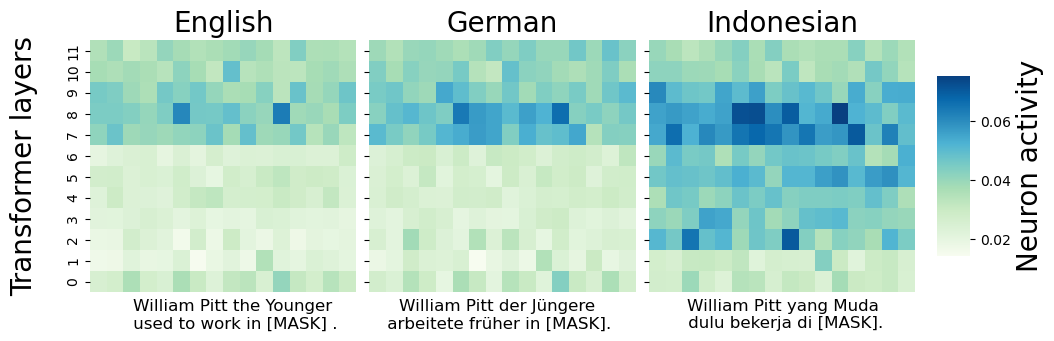

In [8]:
layer_num = 12
rel = "P937"
uuid = "b73bf6c6-3468-4ab8-9f4d-3c6e28259f07"
# rel = "P1001"
# uuid = "c2148de8-608e-475c-89c5-b92d314bc421"
# rel = 'P361'
# uuid = 'ff22944f-428c-40ba-a9f6-c7a063c78de9'
sorted_uuids_en, ranked_uuids_en, probing_en = prober.probe_uuid_by_lang_rel(lang1, rel, cand_size=10000)
sorted_uuids_da, ranked_uuids_da, probing_da = prober.probe_uuid_by_lang_rel(lang2, rel, cand_size=10000)
sorted_uuids_id, ranked_uuids_id, probing_id = prober.probe_uuid_by_lang_rel(lang3, rel, cand_size=10000)
sorted_uuids_ms, ranked_uuids_ms, probing_ms = prober.probe_uuid_by_lang_rel(lang4, rel, cand_size=10000)
top_neuron_en = probing_en[1][uuid]
top_neuron_da = probing_da[1][uuid][:topk]
top_neuron_id = probing_id[1][uuid][:topk]
top_neuron_ms = probing_ms[1][uuid][:topk]
print(dataset.display_uuid(uuid, lang1))
print(dataset.display_uuid(uuid, lang2))
print(dataset.display_uuid(uuid, lang3))
print(dataset.display_uuid(uuid, lang4))

print(f"{measure_neuron_similarity(top_neuron_en, top_neuron_da):.2f}",
f"{measure_neuron_similarity(top_neuron_id, top_neuron_ms):.2f}",
f"{measure_neuron_similarity(top_neuron_en, top_neuron_id):.2f}",
f"{measure_neuron_similarity(top_neuron_en, top_neuron_ms):.2f}",
uuid, dataset.display_uuid(uuid))

neurons1 = probing_en[3][uuid].reshape(layer_num, -1, 16).mean(axis=1)
neurons2 = probing_da[3][uuid].reshape(layer_num, -1, 16).mean(axis=1)
neurons3 = probing_id[3][uuid].reshape(layer_num, -1, 16).mean(axis=1)
neurons4 = probing_ms[3][uuid].reshape(layer_num, -1, 16).mean(axis=1)

import matplotlib.pyplot as plt
import seaborn as sns

# plt.rcParams["svg.fonttype"] = "none"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True

langs = [dataset.display_lang(lang,prefix=False) for lang in [lang1, lang2, lang3]]
fig, axn = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11, 3))

vmin = min(map(np.min, [neurons1, neurons2, neurons3, neurons4]))
vmax = max(map(np.max, [neurons1, neurons2, neurons3, neurons4]))
cbar_ax = fig.add_axes([.87, .2, .03, .6])

# Loop over data and axis to plot heatmaps
# Flatten the axn array for looping
axn_flat = axn.flatten()

# Loop over data, axis, and attributions to plot heatmaps
for i, (ax, lang) in enumerate(zip(axn_flat, langs)):
    # sns.heatmap(data=[neurons1, neurons2, neurons3, neurons4][i], ax=ax, cmap='GnBu')
    sns.heatmap(data=[neurons1, neurons2, neurons3, neurons4][i], ax=ax, cmap='GnBu', cbar=i == 0, cbar_ax=None if i else cbar_ax, vmin=vmin, vmax=vmax)
    ax.set_title(lang, fontsize=20)  # Changed from set_xlabel to set_title for correct labeling
    # ax.set_xlabel(lang, fontsize=20)
    ax.set_xticks([])
    # ax.set_yticks([])
    ax.invert_yaxis()
cbar_ax.set_ylabel('Neuron activity', fontsize=20)
# fig.text(0.5, 0, 'Neurons in each layer (chunked into 16 blocks)', ha='center', va='center', fontsize=15)
fig.text(0.04, 0.5, 'Transformer layers', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(.23, -0.04, 'William Pitt the Younger\n used to work in [MASK] .', ha='center', fontsize=12)
fig.text(.47, -0.04, 'William Pitt der Jüngere\n arbeitete früher in [MASK].', ha='center', fontsize=12)
fig.text(.73, -0.04, 'William Pitt yang Muda\n dulu bekerja di [MASK].', ha='center', fontsize=12)
# fig.text(.76, -0.04, 'Die moedertaal van\n Marie-Anne Chazel is Frans.', ha='center', fontsize=12)
# fig.suptitle("Active neurons of same fact across three languages", fontsize=20, y=1.15)
# plt.tight_layout(rect=[0, 0, .9, 1])

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.1, right=0.85, hspace=0.1, wspace=0.05)
plt.savefig("../../display/figures/neuron_distris.updated.eps", format='eps', transparent=True, dpi=1000, bbox_inches="tight")
# plt.savefig("../../../figures/neuron_distris.transparent.png", transparent=True)


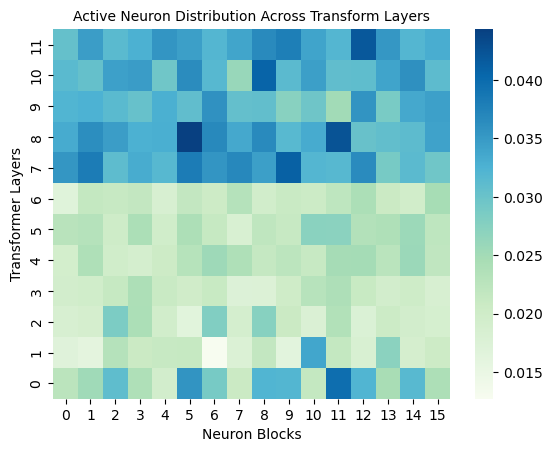

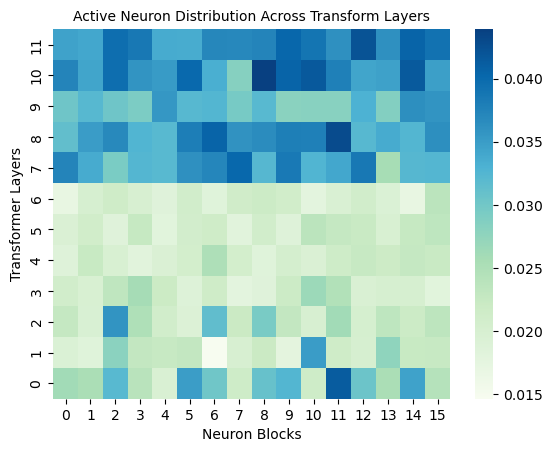

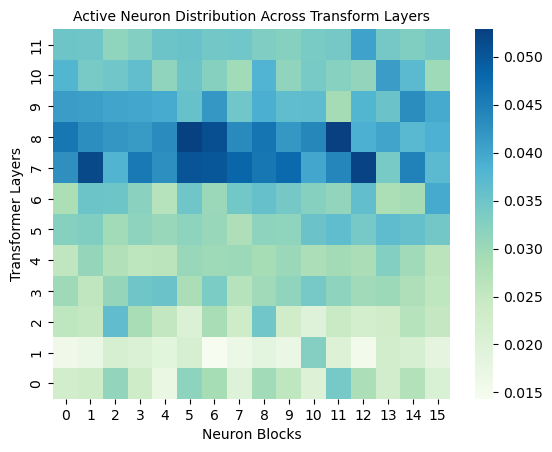

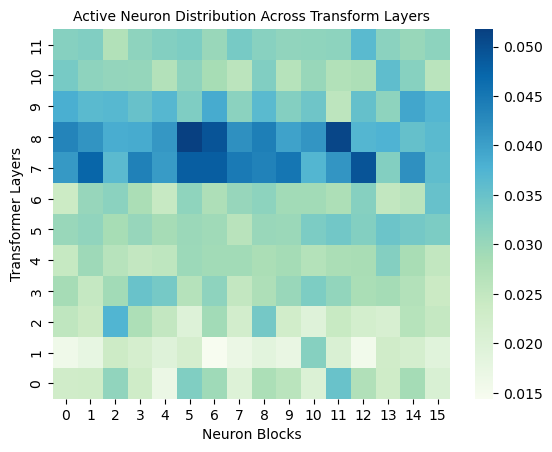

In [9]:
neurons = probing_en[2]
draw_active_neuron_heatmap(neurons, layer_num=prober.model.layer_num)

neurons = probing_da[2]
draw_active_neuron_heatmap(neurons, layer_num=prober.model.layer_num)

neurons = probing_id[2]
draw_active_neuron_heatmap(neurons, layer_num=prober.model.layer_num)

neurons = probing_ms[2]
draw_active_neuron_heatmap(neurons, layer_num=prober.model.layer_num)